In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os

FIG_PATH = Path('figures')
os.makedirs(FIG_PATH, exist_ok=True)
STORE_PATH = Path('store')
os.makedirs(STORE_PATH, exist_ok=True)
rng = np.random.default_rng()

# Loading data from mat file

In [2]:
from hexarena.utils import get_valid_blocks, load_monkey_data, align_monkey_data

filename = STORE_PATH/'foraging_masterTable/data_marco.mat'
meta = get_valid_blocks(filename)
num_blocks = sum([len(meta[s_id]) for s_id in meta])
print('{} blocks across {} sessions found'.format(num_blocks, len(meta)))

104 blocks across 18 sessions found


In [3]:
session_id, block_idx = '20211104', 2
print('Session {}, Block {}'.format(session_id, block_idx))
print(meta[session_id][block_idx])
block_data = load_monkey_data(filename, session_id, block_idx)

Session 20211104, Block 2
{'duration': 1379.96, 'has_pos': False, 'has_gaze': False, 'push': 87, 'reward': 64}


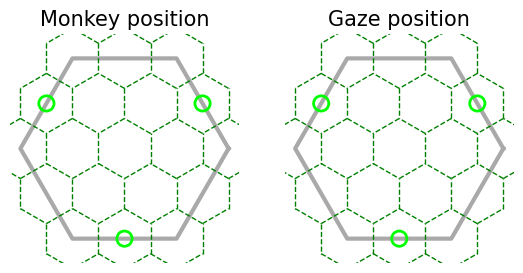

taus: [15.0, 35.0, 21.0]


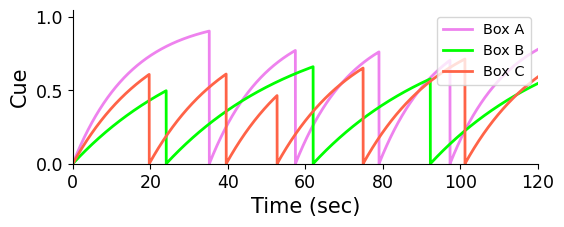

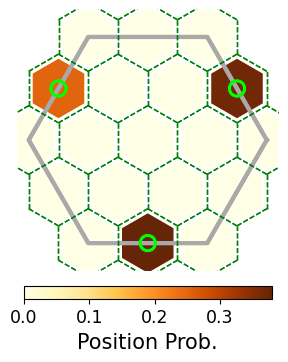

In [4]:
from hexarena.env import SimilarBoxForagingEnv

env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
    },
    boxes=[{'tau': tau, 'sigma': sigma} for tau, sigma in zip(block_data['taus'], block_data['kappas'])],
)

fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))

ax = axes[0]
env.arena.plot_mesh(ax)
pos_xyz = block_data['pos_xyz']/1860
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Monkey position', fontsize='medium')

ax = axes[1]
env.arena.plot_mesh(ax)
pos_xyz = block_data['gaze_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Gaze position', fontsize='medium')

plt.show()

print('taus: {}'.format([box.taus[0] for box in env.boxes]))

fig, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

env_data = env.convert_experiment_data(block_data)
counts, _ = np.histogram(env_data['pos'], np.arange(-0.5, 0.5+env.arena.num_tiles))

fig, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
env.arena.plot_map(ax, counts/counts.sum(), clabel='Position Prob.')

plt.show()

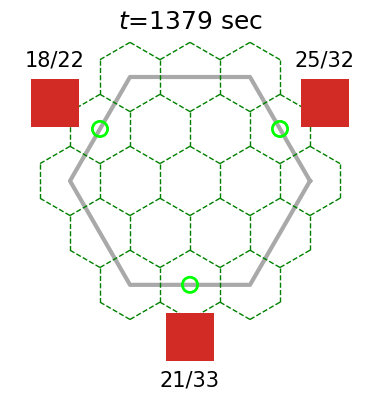

In [5]:
fig, ani = env.play_episode(
    env_data['pos'], env_data['gaze'], rewarded=[None]+[*env_data['success']],
    colors=env_data['colors'], counts=env_data['counts'],
)
ani.save(FIG_PATH/'{}_block-{:d}.gif'.format(session_id, block_idx), fps=6)

# Rotate and flip in space to align boxes

Data from all blocks are converted so that box A ('northeast') is the slowest and box C ('south') is the fastest.

taus: [35.0, 21.0, 15.0]


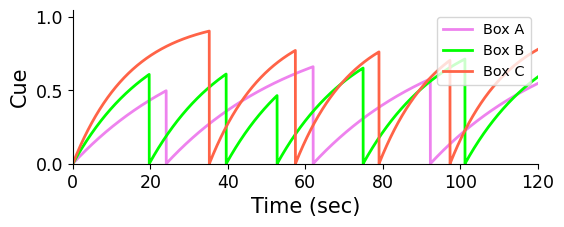

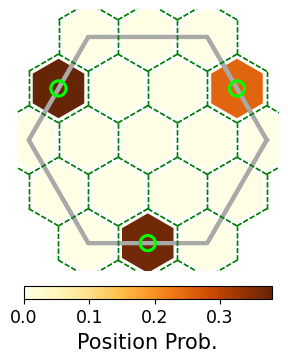

In [6]:
block_data = align_monkey_data(block_data)
env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
    },
    boxes=[{'tau': tau, 'sigma': sigma} for tau, sigma in zip(block_data['taus'], block_data['kappas'])],
)

print('taus: {}'.format([box.taus[0] for box in env.boxes]))

fig, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

env_data = env.convert_experiment_data(block_data)
counts, _ = np.histogram(env_data['pos'], np.arange(-0.5, 0.5+env.arena.num_tiles))

fig, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
env.arena.plot_map(ax, counts/counts.sum(), clabel='Position Prob.')

plt.show()

# Save animation for all blocks

In [ ]:
from jarvis.utils import tqdm

os.makedirs(STORE_PATH/'movies', exist_ok=True)
overwrite = False
with tqdm(total=num_blocks, unit='block') as pbar:
    for session_id in meta:
        pbar.set_description(session_id)
        for block_idx in meta[session_id].keys():
            save_path = STORE_PATH/'movies/{}_block-{:d}_aligned.mp4'.format(session_id, block_idx)
            if os.path.exists(save_path) and not overwrite:
                continue
            block_data = align_monkey_data(load_monkey_data(filename, session_id, block_idx))
            env = SimilarBoxForagingEnv(
                box={
                    '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
                },
                boxes=[{'tau': tau, 'sigma': sigma} for tau, sigma in zip(block_data['taus'], block_data['kappas'])],
            )

            env_data = env.convert_experiment_data(block_data)
            fig, ani = env.play_episode(
                env_data['pos'], env_data['gaze'], rewarded=[None]+[*env_data['success']],
                colors=env_data['colors'], counts=env_data['counts'],
            )
            ani.save(save_path, fps=6)
            pbar.update()
            plt.close(fig)

  0%|                                                                                                         …